In [32]:
import json
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [33]:
pd.set_option('display.max_colwidth', 100)
sns.set_theme(style="whitegrid")

In [34]:
RAW_DIR = "../data/output"      
INTERIM_DIR = "../data/interim"  
os.makedirs(INTERIM_DIR, exist_ok=True)

In [35]:
def extract_date_from_url(url):
    
    if not isinstance(url, str): return None
    try:
        match = re.search(r'(20[1-2]\d)(\d{2})(\d{2})', url)
        if match:
            year, month, day = match.group(1), match.group(2), match.group(3)
            if 1 <= int(month) <= 12 and 1 <= int(day) <= 31:
                return f"{year}-{month}-{day}"
    except:
        pass
    return None

def clean_row(row):
    # 1. Fix Tiêu đề
    title = str(row.get('title', '')).strip()
    content = str(row.get('content', '')).strip()
    # Xóa các ký tự \n, \r, \t thừa
    content = re.sub(r'[\n\r\t]+', ' ', content)
    content = re.sub(r'\s+', ' ', content).strip()
    

    # Nếu mất title, lấy 15 từ đầu tiên của content làm title tạm
    if not title and content:
        title = " ".join(content.split()[:15]) + "..."
        
    raw_date = row.get('published_date')
    url_date = extract_date_from_url(row.get('url'))
    
    final_date = url_date if url_date else raw_date
    
    return {
        "ticker": row.get('ticker'),
        "source": row.get('source'),
        "date": final_date,
        "title": title,
        "content": content,
        "url": row.get('url')
    }


In [36]:
json_files = glob.glob(os.path.join(RAW_DIR, "*_news.json"))
print(f"{len(json_files)} file dữ liệu thô.")

all_data = []

for filepath in json_files:
    with open(filepath, 'r', encoding='utf-8') as f:
        raw_items = json.load(f)
        
    print(f"Processing {os.path.basename(filepath)}: {len(raw_items)} bài.")
    
    for item in raw_items:
        clean_item = clean_row(item)
        if clean_item['content'] and clean_item['date']:
            all_data.append(clean_item)

df = pd.DataFrame(all_data)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df = df.dropna(subset=['date'])

print(f"\nTổng số bài báo sạch: {len(df)}")
df.head(3)


5 file dữ liệu thô.
Processing BID_news.json: 4997 bài.
Processing FPT_news.json: 4123 bài.
Processing VIC_news.json: 5614 bài.
Processing VJC_news.json: 3297 bài.
Processing VNM_news.json: 2602 bài.

Tổng số bài báo sạch: 19960


,ticker,source,date,title,content,url
0,BID,CafeF,2025-12-02,"Công an Cao Bằng tuyên truyền, phân tích và hướng dẫn bà H nhận diện...","Công an Cao Bằng tuyên truyền, phân tích và hướng dẫn bà H nhận diện thủ đoạn lừa đảo. (Ảnh: Côn...",https://cafef.vn/nguoi-phu-nu-den-ngan-hang-bidv-chuyen-250-trieu-dong-nhan-vien-giao-dich-khang...
1,BID,CafeF,2025-11-10,TUTA ký hợp tác với Ngân hàng BIDV: Bảo chứng vàng từ sức mạnh hợp lực,"TIN MỚI Ngay từ những ngày đầu định hình ý tưởng phát triển dự án, Royal Mansion đã được chủ đầu...",https://cafef.vn/tuta-ky-hop-tac-voi-ngan-hang-bidv-bao-chung-vang-tu-suc-manh-hop-luc-188251110...
2,BID,CafeF,2025-10-12,"Hai phường của Hà Nội diện tích chưa đến 2 km2 nhưng là nơi đặt ""đại bản doanh"" hàng chục ngân h...","TIN MỚI Quận Hoàn Kiếm (cũ) từng được xem là ""Phố Wall"" giữa lòng Hà Nội, là địa bàn tập trung n...",https://cafef.vn/hai-phuong-cua-ha-noi-dien-tich-chua-den-2-km2-nhung-la-noi-dat-dai-ban-doanh-h...


C:\Users\phamd\AppData\Local\Temp\ipykernel_2064\1939057979.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ticker', palette='viridis')


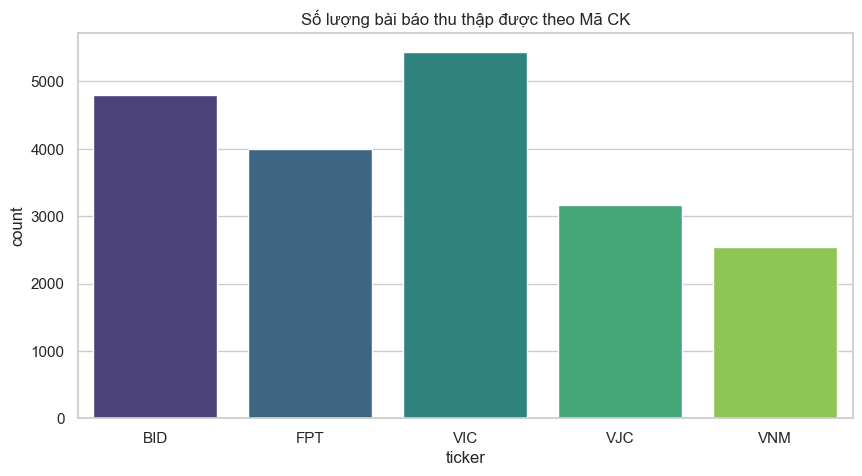

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='ticker', palette='viridis')
plt.title("Số lượng bài báo thu thập được theo Mã CK")
plt.show()

In [38]:
wrong_date_df = df[df['date'] < '2022-01-01']
print(wrong_date_df[['url', 'date', 'title']].count())

url      1468
date     1468
title    1468
dtype: int64


In [39]:
df = df[df['date'] >= '2022-01-01']


In [40]:
df.count()

ticker     18492
source     18492
date       18492
title      18492
content    18492
url        18492
dtype: int64

In [41]:
# thống kê số lượng bài báo theo từng năm
df['year'] = df['date'].dt.year
yearly_counts = df['year'].value_counts().sort_index()
print(yearly_counts)

year
2022    2551
2023    2741
2024    3798
2025    9400
2026       1
2028       1
Name: count, dtype: int64


In [42]:
# Xóa 2 bài báo năm 2026 và 2028
df = df[~df['year'].isin([2026, 2028])]

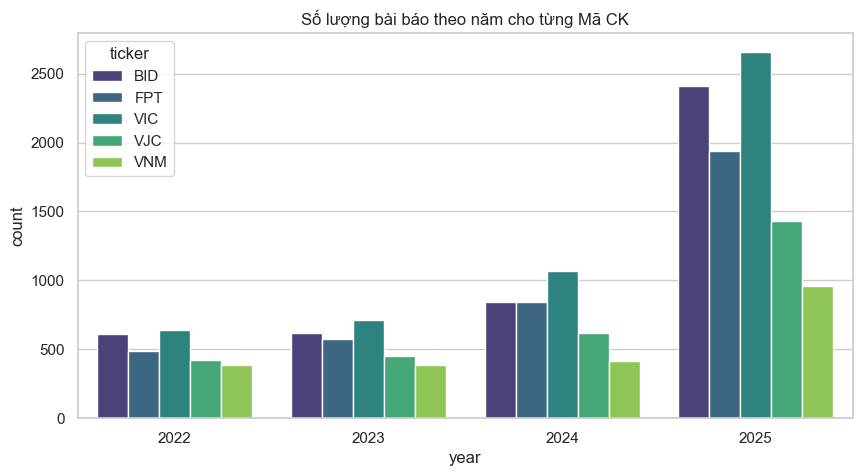

In [43]:
# Vẽ biểu đồ số lượng bài báo theo năm cho từng ticker
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='year', hue='ticker', palette='viridis')
plt.title("Số lượng bài báo theo năm cho từng Mã CK")
plt.show()

In [44]:
tickers = df['ticker'].unique()

for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker].sort_values(by='date')
    
    df_ticker['date'] = df_ticker['date'].dt.strftime('%Y-%m-%d')
    
    clean_data = df_ticker.to_dict(orient='records')
    
    output_path = os.path.join(INTERIM_DIR, f"{ticker}_clean.json")
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(clean_data, f, ensure_ascii=False, indent=4)
        print(f"Đã lưu: {output_path} ({len(clean_data)} bài)")


Đã lưu: ../data/interim\BID_clean.json (4481 bài)
Đã lưu: ../data/interim\FPT_clean.json (3845 bài)
Đã lưu: ../data/interim\VIC_clean.json (5082 bài)
Đã lưu: ../data/interim\VJC_clean.json (2930 bài)
Đã lưu: ../data/interim\VNM_clean.json (2152 bài)
